In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil

In [2]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 650
IMAGE_WIDTH = 450

SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                

In [4]:
## Resample training data
#resample_data(train_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 8018 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
import os

# Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = False
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model without L2 regularization
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers without L2 regularization   
x = Dense(256, activation='relu')(x)       
x = BatchNormalization()(x) 
x = Dropout(0.3)(x)                   
x = Dense(128, activation='relu')(x)    
x = BatchNormalization()(x)          
x = Dropout(0.3)(x)                   
x = Flatten()(x)                      
x = Dense(64, activation='relu')(x)     
x = Dropout(0.3)(x)                    
x = Dense(32, activation='relu')(x)     


# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint( 
    'withoutresample and regulazation4.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


80134624/80134624 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 650, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 650, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 650, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 325, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 325, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 325, 225, 128)     147584    
                                                              

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 2 - Validation Loss: 0.9892, Validation Accuracy: 0.6723, Validation Precision: 0.5231

Epoch 2: val_loss improved from 1.21473 to 0.98918, saving model to withoutresample and regulazation4.h5
502/502 - 313s - loss: 1.1826 - acc: 0.6468 - val_loss: 0.9892 - val_acc: 0.6723 - lr: 1.0000e-04 - 313s/epoch - 623ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 3 - Validation Loss: 0.9698, Validation Accuracy: 0.6713, Validation Precision: 0.5270

Epoch 3: val_loss improved from 0.98918 to 0.96975, saving model to withoutresample and regulazation4.h5
502/502 - 311s - loss: 1.0977 - acc: 0.6593 - val_loss: 0.9698 - val_acc: 0.6713 - lr: 1.0000e-04 - 311s/epoch - 620ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 4 - Validation Loss: 0.9635, Validation Accuracy: 0.6728, Validation Precision: 0.5153

Epoch 4: val_loss improved from 0.96975 to 0.96352, saving model to withoutresample and regulazation4.h5
502/502 - 313s - loss: 1.0697 - acc: 0.6613 - val_loss: 0.9635 - val_acc: 0.6728 - lr: 1.0000e-04 - 313s/epoch - 624ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 5 - Validation Loss: 0.9655, Validation Accuracy: 0.6778, Validation Precision: 0.5292

Epoch 5: val_loss did not improve from 0.96352
502/502 - 311s - loss: 1.0412 - acc: 0.6643 - val_loss: 0.9655 - val_acc: 0.6778 - lr: 1.0000e-04 - 311s/epoch - 620ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 6 - Validation Loss: 0.9578, Validation Accuracy: 0.6758, Validation Precision: 0.5415

Epoch 6: val_loss improved from 0.96352 to 0.95784, saving model to withoutresample and regulazation4.h5
502/502 - 312s - loss: 1.0352 - acc: 0.6670 - val_loss: 0.9578 - val_acc: 0.6758 - lr: 1.0000e-04 - 312s/epoch - 621ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 286ms/step
Epoch 7 - Validation Loss: 0.9873, Validation Accuracy: 0.6793, Validation Precision: 0.5559

Epoch 7: val_loss did not improve from 0.95784
502/502 - 312s - loss: 1.0162 - acc: 0.6681 - val_loss: 0.9873 - val_acc: 0.6793 - lr: 1.0000e-04 - 312s/epoch - 622ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 8 - Validation Loss: 0.9685, Validation Accuracy: 0.6808, Validation Precision: 0.5585

Epoch 8: val_loss did not improve from 0.95784
502/502 - 313s - loss: 0.9980 - acc: 0.6701 - val_loss: 0.9685 - val_acc: 0.6808 - lr: 1.0000e-04 - 313s/epoch - 624ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 9 - Validation Loss: 0.9126, Validation Accuracy: 0.6848, Validation Precision: 0.6237

Epoch 9: val_loss improved from 0.95784 to 0.91262, saving model to withoutresample and regulazation4.h5
502/502 - 322s - loss: 0.9868 - acc: 0.6707 - val_loss: 0.9126 - val_acc: 0.6848 - lr: 1.0000e-04 - 322s/epoch - 642ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 10 - Validation Loss: 0.9204, Validation Accuracy: 0.6823, Validation Precision: 0.5846

Epoch 10: val_loss did not improve from 0.91262
502/502 - 345s - loss: 0.9820 - acc: 0.6705 - val_loss: 0.9204 - val_acc: 0.6823 - lr: 1.0000e-04 - 345s/epoch - 687ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 11 - Validation Loss: 0.9054, Validation Accuracy: 0.6833, Validation Precision: 0.6466

Epoch 11: val_loss improved from 0.91262 to 0.90535, saving model to withoutresample and regulazation4.h5
502/502 - 312s - loss: 0.9792 - acc: 0.6732 - val_loss: 0.9054 - val_acc: 0.6833 - lr: 1.0000e-04 - 312s/epoch - 622ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 286ms/step
Epoch 12 - Validation Loss: 0.9078, Validation Accuracy: 0.6843, Validation Precision: 0.5908

Epoch 12: val_loss did not improve from 0.90535
502/502 - 310s - loss: 0.9555 - acc: 0.6726 - val_loss: 0.9078 - val_acc: 0.6843 - lr: 1.0000e-04 - 310s/epoch - 618ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 37s 295ms/step
Epoch 13 - Validation Loss: 0.8919, Validation Accuracy: 0.6868, Validation Precision: 0.6221

Epoch 13: val_loss improved from 0.90535 to 0.89194, saving model to withoutresample and regulazation4.h5
502/502 - 384s - loss: 0.9529 - acc: 0.6724 - val_loss: 0.8919 - val_acc: 0.6868 - lr: 1.0000e-04 - 384s/epoch - 765ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 37s 293ms/step
Epoch 14 - Validation Loss: 0.8953, Validation Accuracy: 0.6823, Validation Precision: 0.5815

Epoch 14: val_loss did not improve from 0.89194
502/502 - 411s - loss: 0.9588 - acc: 0.6766 - val_loss: 0.8953 - val_acc: 0.6823 - lr: 1.0000e-04 - 411s/epoch - 818ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 291ms/step
Epoch 15 - Validation Loss: 0.9364, Validation Accuracy: 0.6903, Validation Precision: 0.6286

Epoch 15: val_loss did not improve from 0.89194
502/502 - 408s - loss: 0.9472 - acc: 0.6775 - val_loss: 0.9364 - val_acc: 0.6903 - lr: 1.0000e-04 - 408s/epoch - 812ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 16 - Validation Loss: 0.8818, Validation Accuracy: 0.6843, Validation Precision: 0.6055

Epoch 16: val_loss improved from 0.89194 to 0.88181, saving model to withoutresample and regulazation4.h5
502/502 - 386s - loss: 0.9434 - acc: 0.6786 - val_loss: 0.8818 - val_acc: 0.6843 - lr: 1.0000e-04 - 386s/epoch - 769ms/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 286ms/step
Epoch 17 - Validation Loss: 0.8984, Validation Accuracy: 0.6843, Validation Precision: 0.6273

Epoch 17: val_loss did not improve from 0.88181
502/502 - 336s - loss: 0.9388 - acc: 0.6725 - val_loss: 0.8984 - val_acc: 0.6843 - lr: 1.0000e-04 - 336s/epoch - 670ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 284ms/step
Epoch 18 - Validation Loss: 0.9423, Validation Accuracy: 0.6838, Validation Precision: 0.5812

Epoch 18: val_loss did not improve from 0.88181
502/502 - 311s - loss: 0.9336 - acc: 0.6770 - val_loss: 0.9423 - val_acc: 0.6838 - lr: 1.0000e-04 - 311s/epoch - 620ms/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 284ms/step
Epoch 19 - Validation Loss: 0.8951, Validation Accuracy: 0.6818, Validation Precision: 0.5992

Epoch 19: val_loss did not improve from 0.88181
502/502 - 311s - loss: 0.9247 - acc: 0.6776 - val_loss: 0.8951 - val_acc: 0.6818 - lr: 1.0000e-04 - 311s/epoch - 620ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 20 - Validation Loss: 0.9180, Validation Accuracy: 0.6898, Validation Precision: 0.6500

Epoch 20: val_loss did not improve from 0.88181
502/502 - 311s - loss: 0.9218 - acc: 0.6767 - val_loss: 0.9180 - val_acc: 0.6898 - lr: 1.0000e-04 - 311s/epoch - 620ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 286ms/step
Epoch 21 - Validation Loss: 0.8779, Validation Accuracy: 0.6843, Validation Precision: 0.6499

Epoch 21: val_loss improved from 0.88181 to 0.87788, saving model to withoutresample and regulazation4.h5
502/502 - 313s - loss: 0.9293 - acc: 0.6790 - val_loss: 0.8779 - val_acc: 0.6843 - lr: 1.0000e-04 - 313s/epoch - 623ms/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 22 - Validation Loss: 0.9021, Validation Accuracy: 0.6818, Validation Precision: 0.6387

Epoch 22: val_loss did not improve from 0.87788
502/502 - 312s - loss: 0.9219 - acc: 0.6788 - val_loss: 0.9021 - val_acc: 0.6818 - lr: 1.0000e-04 - 312s/epoch - 621ms/step
Epoch 23/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 23 - Validation Loss: 0.8821, Validation Accuracy: 0.6848, Validation Precision: 0.6132

Epoch 23: val_loss did not improve from 0.87788
502/502 - 312s - loss: 0.9088 - acc: 0.6860 - val_loss: 0.8821 - val_acc: 0.6848 - lr: 1.0000e-04 - 312s/epoch - 621ms/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 24 - Validation Loss: 0.8584, Validation Accuracy: 0.6863, Validation Precision: 0.5947

Epoch 24: val_loss improved from 0.87788 to 0.85835, saving model to withoutresample and regulazation4.h5
502/502 - 311s - loss: 0.9114 - acc: 0.6810 - val_loss: 0.8584 - val_acc: 0.6863 - lr: 1.0000e-04 - 311s/epoch - 620ms/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 25 - Validation Loss: 0.8738, Validation Accuracy: 0.6793, Validation Precision: 0.6419

Epoch 25: val_loss did not improve from 0.85835
502/502 - 311s - loss: 0.9091 - acc: 0.6838 - val_loss: 0.8738 - val_acc: 0.6793 - lr: 1.0000e-04 - 311s/epoch - 620ms/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 26 - Validation Loss: 0.8870, Validation Accuracy: 0.6908, Validation Precision: 0.6404

Epoch 26: val_loss did not improve from 0.85835
502/502 - 310s - loss: 0.9027 - acc: 0.6878 - val_loss: 0.8870 - val_acc: 0.6908 - lr: 1.0000e-04 - 310s/epoch - 617ms/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 287ms/step
Epoch 27 - Validation Loss: 0.8833, Validation Accuracy: 0.6938, Validation Precision: 0.6340

Epoch 27: val_loss did not improve from 0.85835
502/502 - 310s - loss: 0.9075 - acc: 0.6889 - val_loss: 0.8833 - val_acc: 0.6938 - lr: 1.0000e-04 - 310s/epoch - 618ms/step
Epoch 28/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 290ms/step
Epoch 28 - Validation Loss: 0.8468, Validation Accuracy: 0.6913, Validation Precision: 0.6374

Epoch 28: val_loss improved from 0.85835 to 0.84682, saving model to withoutresample and regulazation4.h5
502/502 - 315s - loss: 0.9033 - acc: 0.6835 - val_loss: 0.8468 - val_acc: 0.6913 - lr: 1.0000e-04 - 315s/epoch - 627ms/step
Epoch 29/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 288ms/step
Epoch 29 - Validation Loss: 0.9313, Validation Accuracy: 0.6673, Validation Precision: 0.6207

Epoch 29: val_loss did not improve from 0.84682
502/502 - 312s - loss: 0.8920 - acc: 0.6863 - val_loss: 0.9313 - val_acc: 0.6673 - lr: 1.0000e-04 - 312s/epoch - 621ms/step
Epoch 30/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 288ms/step
Epoch 30 - Validation Loss: 0.8947, Validation Accuracy: 0.6818, Validation Precision: 0.5747

Epoch 30: val_loss did not improve from 0.84682
502/502 - 311s - loss: 0.8911 - acc: 0.6881 - val_loss: 0.8947 - val_acc: 0.6818 - lr: 1.0000e-04 - 311s/epoch - 619ms/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 37s 294ms/step
Epoch 31 - Validation Loss: 0.9044, Validation Accuracy: 0.6888, Validation Precision: 0.5892

Epoch 31: val_loss did not improve from 0.84682
502/502 - 355s - loss: 0.8868 - acc: 0.6835 - val_loss: 0.9044 - val_acc: 0.6888 - lr: 1.0000e-04 - 355s/epoch - 708ms/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 289ms/step
Epoch 32 - Validation Loss: 0.8794, Validation Accuracy: 0.6843, Validation Precision: 0.6209

Epoch 32: val_loss did not improve from 0.84682
502/502 - 399s - loss: 0.8840 - acc: 0.6862 - val_loss: 0.8794 - val_acc: 0.6843 - lr: 1.0000e-04 - 399s/epoch - 794ms/step
Epoch 33/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 286ms/step
Epoch 33 - Validation Loss: 0.8541, Validation Accuracy: 0.6953, Validation Precision: 0.6374

Epoch 33: val_loss did not improve from 0.84682
502/502 - 390s - loss: 0.8858 - acc: 0.6858 - val_loss: 0.8541 - val_acc: 0.6953 - lr: 1.0000e-04 - 390s/epoch - 776ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

126/126 [==============================] - 36s 286ms/step
Final Precision: 0.6374
Final Recall: 0.6913
Final F1 Score: 0.6463


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 33s 341ms/step - loss: 1.0263 - acc: 0.6376
Test accuracy: 0.6376237869262695


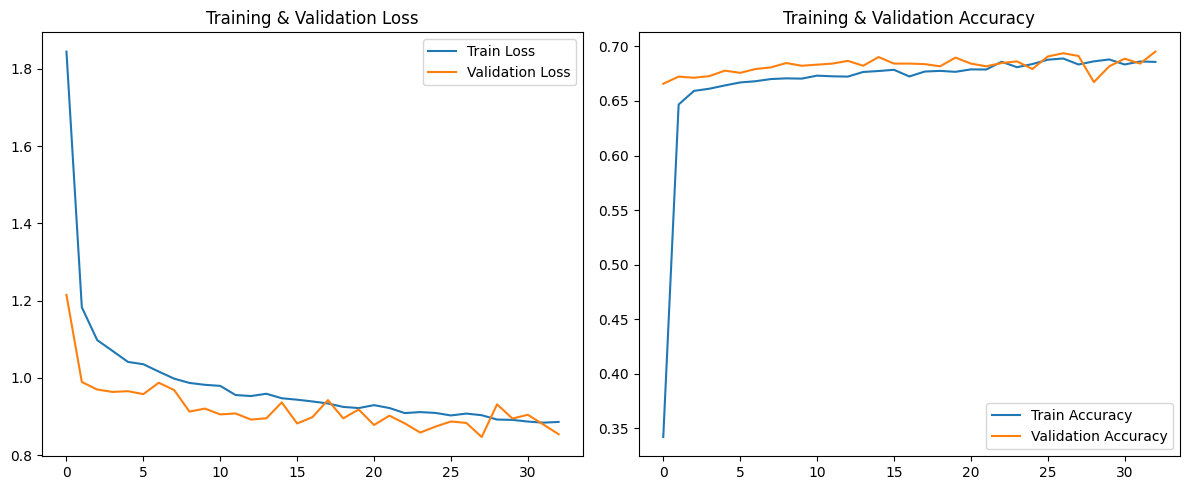

In [7]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

502/502 [==============================] - 309s 615ms/step


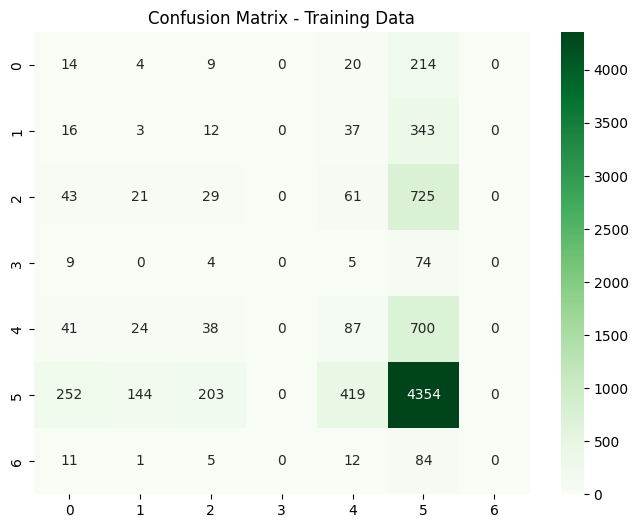

126/126 [==============================] - 36s 287ms/step


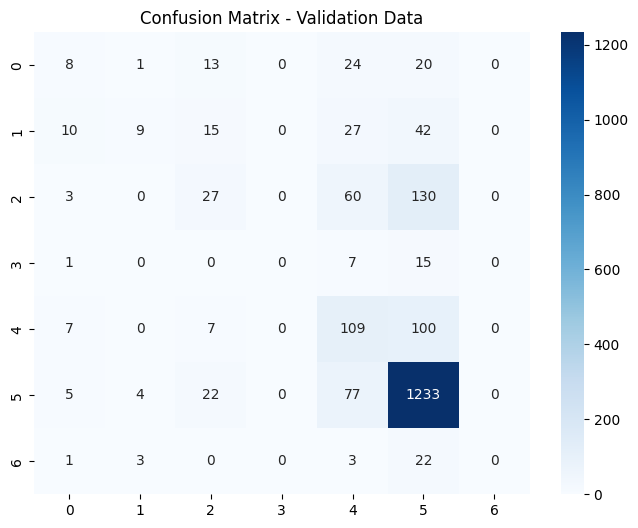

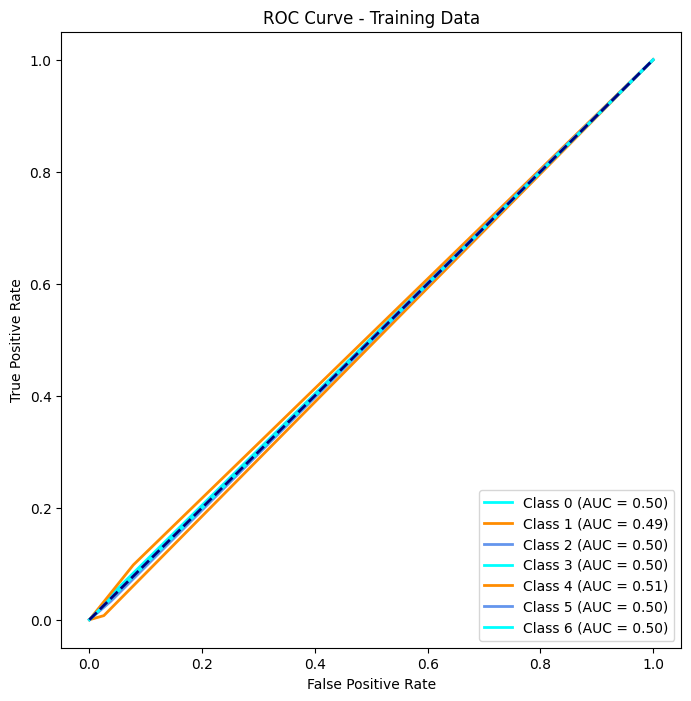

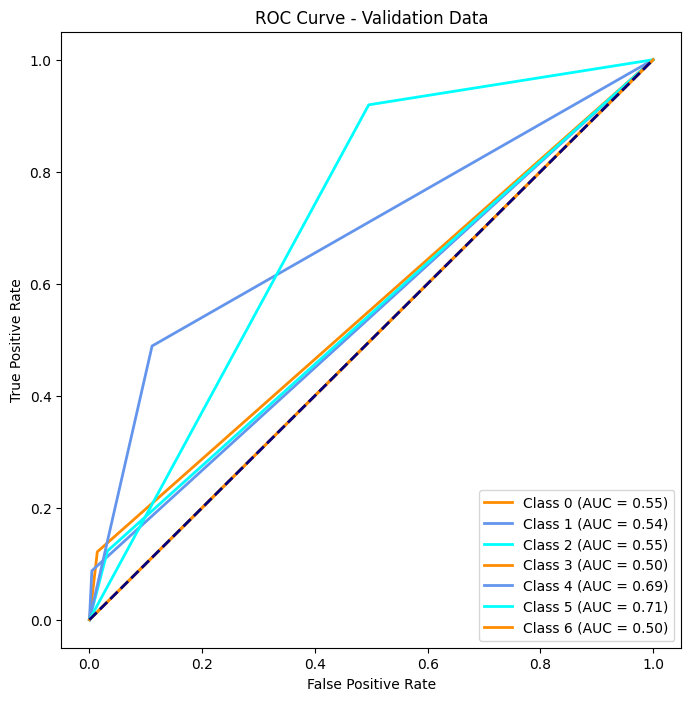

In [8]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()


In [9]:
x, y  = train_generator.__getitem__(0)

y

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [10]:
x, y  = test_generator.__getitem__(0)

y

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [11]:
x, y  = val_generator.__getitem__(0)

y

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [12]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(r"C:\Users\guitar123\Desktop\Senior Project\Model1\original model\InceptionResnetV2\test resample\without resample\withoutresample and regulazation4.h5")

# Verify the model structure
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 650, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 650, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 650, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 325, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 325, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 325, 225, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 162, 112, 128)     0     

In [13]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 8018 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [14]:
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
val_score = model.evaluate(val_generator)
print('val accuracy:', val_score[1])
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

502/502 [==============================] - 290s 566ms/step - loss: 0.8269 - acc: 0.7055
Train accuracy: 0.7055375576019287
126/126 [==============================] - 37s 289ms/step - loss: 0.8516 - acc: 0.6843
val accuracy: 0.684289276599884
95/95 [==============================] - 30s 316ms/step - loss: 1.0280 - acc: 0.6416
Test accuracy: 0.6415841579437256


In [15]:
x, y  = test_generator.__getitem__(0)

y

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

502/502 [==============================] - 285s 567ms/step


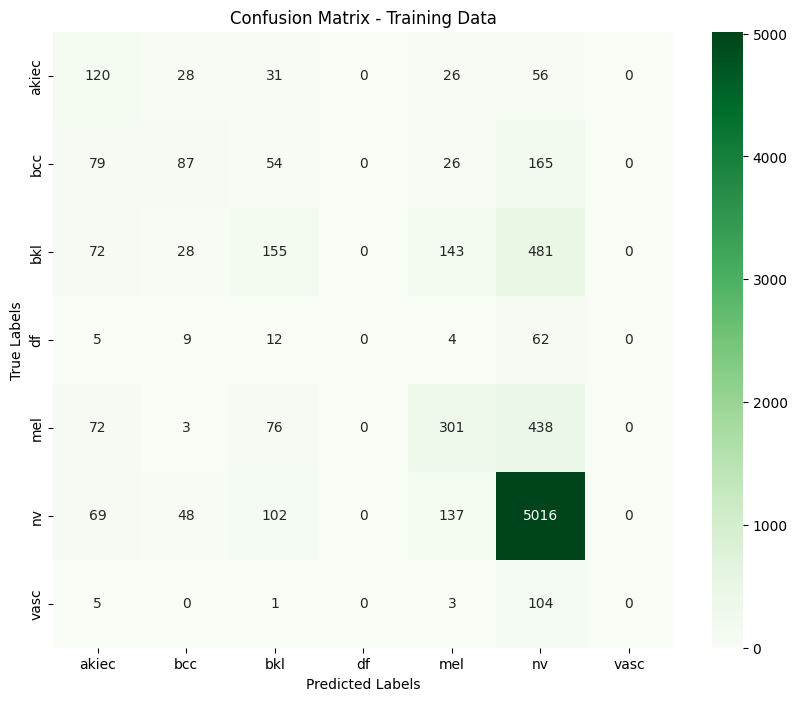

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.28      0.46      0.35       261
         bcc       0.43      0.21      0.28       411
         bkl       0.36      0.18      0.24       879
          df       0.00      0.00      0.00        92
         mel       0.47      0.34      0.39       890
          nv       0.79      0.93      0.86      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.71      8018
   macro avg       0.33      0.30      0.30      8018
weighted avg       0.65      0.71      0.67      8018

126/126 [==============================] - 33s 261ms/step


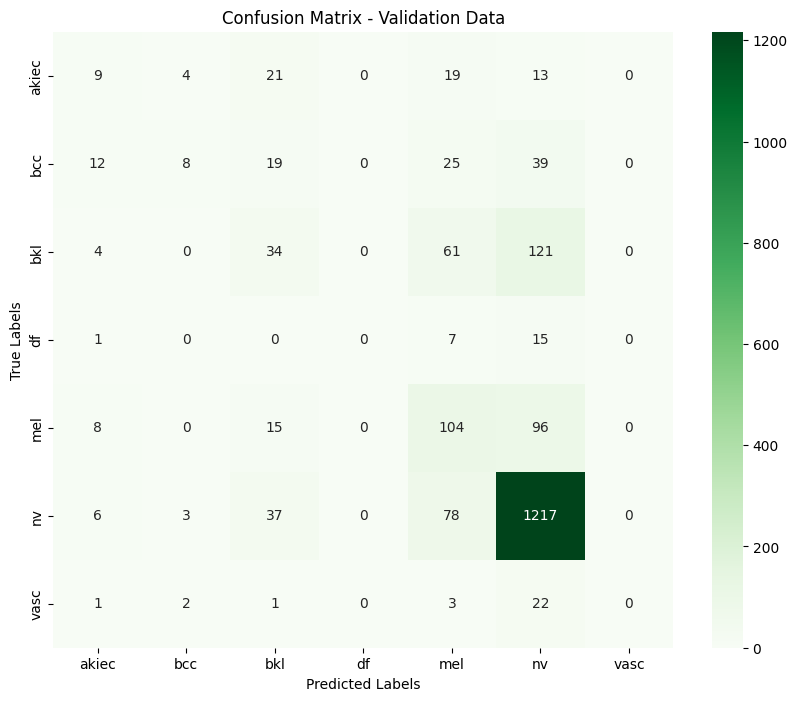

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.22      0.14      0.17        66
         bcc       0.47      0.08      0.13       103
         bkl       0.27      0.15      0.20       220
          df       0.00      0.00      0.00        23
         mel       0.35      0.47      0.40       223
          nv       0.80      0.91      0.85      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.68      2005
   macro avg       0.30      0.25      0.25      2005
weighted avg       0.63      0.68      0.65      2005

95/95 [==============================] - 25s 262ms/step


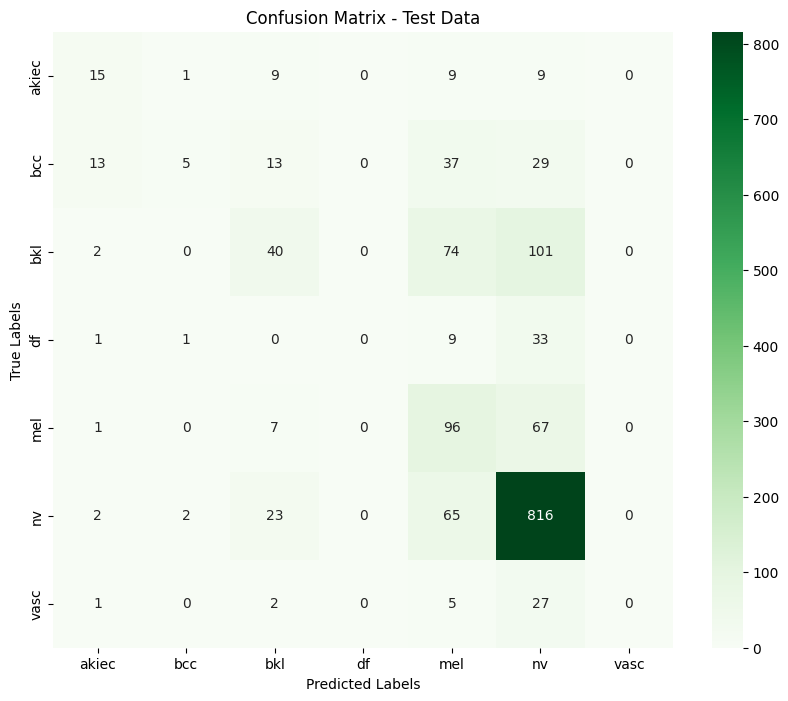

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.43      0.35      0.38        43
         bcc       0.56      0.05      0.09        97
         bkl       0.43      0.18      0.26       217
          df       0.00      0.00      0.00        44
         mel       0.33      0.56      0.41       171
          nv       0.75      0.90      0.82       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.64      1515
   macro avg       0.36      0.29      0.28      1515
weighted avg       0.60      0.64      0.59      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [16]:
from sklearn.metrics import classification_report
# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(r"C:\Users\guitar123\Desktop\Senior Project\Model2\original model\InceptionResnetV2\test resample\without resample\VGG19\withoutresample and regulazation4.h5")

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

y_true = train_generator.classes
y_pred = model.predict(train_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Train accuracy:', accuracy)
print('Train Precision:', precision)
print('Train Recall:', recall)
print('Train F1 Score:', f1_score)

y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Val accuracy:', accuracy)
print('Val Precision:', precision)
print('Val Recall:', recall)
print('Val F1 Score:', f1_score)

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)


from sklearn.metrics import classification_report
# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')